<a href="https://colab.research.google.com/github/Shallom12/myproject/blob/main/Multi_Kernel_1D_CNN%EC%9C%BC%EB%A1%9C_%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2021년 10월 9일에 마지막으로 테스트하였습니다.  

이 자료는 '위키독스 딥 러닝을 이용한 자연어 처리 입문, 네이버 영화 리뷰 튜토리얼입니다.'

링크 : https://wikidocs.net/85337

# 11-05 Multi-Kernel 1D CNN으로 네이버 영화 리뷰 분류하기
---

다양한 크기의 커널들을 혼합하여 네이버 영화 리뷰를 분류해보겠습니다.

---
## 1. 네이버 영화 데이터 수집 & 전처리
---
모든 전처리는 RNN을 이용한 텍스트 분류 챕터의 네이버 영화 리뷰 분류하기( https://wikidocs.net/44249 )와 동일하게 수행하였다고 가정합니다.

In [1]:
import tensorflow as tf
tf.__version__


'2.17.0'

In [2]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 24.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x793a869c3370>)

In [5]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [6]:
print('훈련 샘플의 개수 :', len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트 샘플의 개수 :', len(test_data)) # 테스트용 리뷰 개수 출력

훈련 샘플의 개수 : 150000
테스트 샘플의 개수 : 50000


In [7]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [9]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [10]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: xlabel='label'>

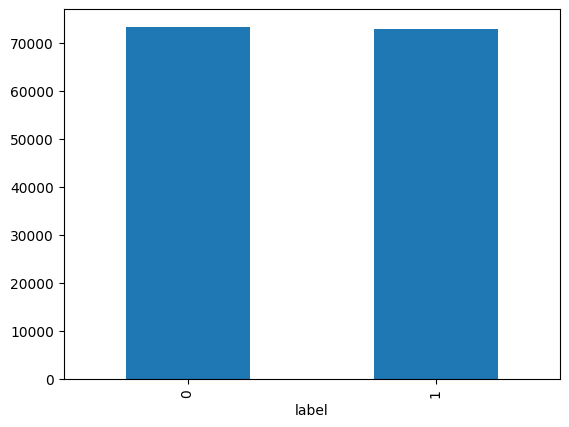

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [13]:
print(train_data.isnull().values.any())

True


In [14]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [15]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [17]:
print(len(train_data))

146182


In [18]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

<ipython-input-18-7c6e437d390d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [19]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


<ipython-input-19-c2f9538d5bc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
<ipython-input-19-c2f9538d5bc3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document

In [20]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label


In [21]:
train_data = train_data.dropna(how = 'any')

In [22]:
print(len(train_data))

146182


In [23]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49157


<ipython-input-23-c182d8fa0991>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


In [24]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49157


In [25]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [26]:
okt = Okt()

In [ ]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

 26%|██▌       | 38008/146182 [03:20<05:42, 315.95it/s]

In [ ]:
print(X_train)

In [ ]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

In [ ]:
print('전처리 후 테스트용 샘플의 개수 :', len(X_test))

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

In [ ]:
print(tokenizer.word_counts.items())

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size) # 빈도수 2 이하인 단어는 제거
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
print(len(X_train))
print(len(y_train))

In [ ]:
print(X_train[:3])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [ ]:
print(drop_train)

In [ ]:
len(drop_train)

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

In [ ]:
print(len(X_train))
print(len(y_train))

In [ ]:
print(len(X_test))
print(len(y_test))

In [ ]:
X_test = np.delete(X_test, drop_test, axis=0)

In [ ]:
y_test = np.delete(y_test, drop_test, axis=0)

In [ ]:
print(len(X_test))
print(len(y_test))

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

In [ ]:
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

---
## 2. Multi-Kernel 1D CNN으로 네이버 영화 리뷰 분류하기
---
케라스에서 다수의 커널을 사용할 경우에는 Funtional API를 사용하여 구현합니다. 우선 필요한 도구들을 임포트합니다. 하이퍼파라미터인 임베딩 벡터의 차원은 128, 드롭아웃 비율은 0.5와 0.8 두 가지를 사용합니다. 각 커널의 개수는 128개를 사용하고, 전결합층(Fully Connected Layer)을 은닉층을 추가로 사용했는데, 은닉층의 뉴런 수는 128입니다.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

입력 층과 임베딩 층을 정의합니다. 임베딩 층 이후에는 드롭아웃의 인자값이 0.5. 즉, 50% 드롭아웃을 해주었습니다.

In [ ]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

3, 4, 5의 크기를 가지는 커널을 각각 128개 사용합니다. 그리고 이들을 맥스풀링합니다.

In [ ]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

각 맥스풀링한 결과를 연결(concatenate)합니다. 그리고 이를 전결합층(Fully Connected Layer)을 사용한 은닉층으로 전달합니다. 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델입니다. 이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다. 하이퍼파라미터인 배치 크기는 64이며, 10 에포크를 수행합니다.

EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미입니다. ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다. validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [ ]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
model.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
%%time
# Epoch 7: val_acc did not improve from 0.84807
# 1815/1815 - 133s - loss: 0.2283 - acc: 0.9082 - val_loss: 0.3862 - val_acc: 0.8408 - 133s/epoch - 73ms/step
# Epoch 7: early stopping
# CPU times: user 27min 54s, sys: 22.7 s, total: 28min 16s
# Wall time: 15min 2s
# <keras.callbacks.History at 0x7f1a1a30a820>
model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split = 0.2, verbose=2, callbacks=[es, mc])

학습 후 저장한 모델을 로드하여 테스트 데이터에 대해서 평가합니다.

In [ ]:
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

84%의 정확도를 얻었습니다.

---
## 3. 리뷰 예측해보기
---

RNN을 이용한 텍스트 분류 챕터의 네이버 영화 리뷰 분류하기 실습( https://wikidocs.net/44249 )에서 사용한 동일한 예측 함수 sentiment_predict를 사용했습니다.

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

In [ ]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

In [ ]:
sentiment_predict('감독 뭐하는 놈이냐?')

In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

In [ ]:
sentiment_predict('죽인다')